<a href="https://colab.research.google.com/github/AsadullaAshurov/MedMNIST/blob/main/pneumonia_mnist_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install libarchive-c

In [2]:
pip install medmnist

100%|██████████| 4.17M/4.17M [00:00<00:00, 4.69MB/s]


Data info: {'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b

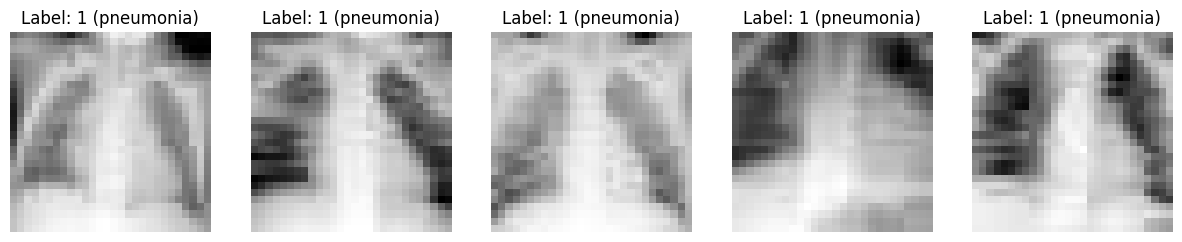

In [3]:
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import numpy as np

def explore_data():
    data_flag = 'pneumoniamnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])

    # load the data
    train_dataset = DataClass(split='train', download=True)
    test_dataset = DataClass(split='test', download=True)

    print(f"Data info: {info}")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Visualize some samples
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, target = train_dataset[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {target[0]} ({info['label'][str(target[0])]})")
        axes[i].axis('off')
    plt.savefig('data_samples.png')
    print("Saved data_samples.png")

if __name__ == "__main__":
    explore_data()


CNN Classification

Using device: cpu
Loading datasets...
Train: 4708, Val: 524, Test: 624
Class weights - Normal: 1214, Pneumonia: 3494, Pos weight: 0.3475
Epoch 1/3, Batch 0/74, Loss: 0.3491
Epoch 1/3, Batch 20/74, Loss: 0.1061
Epoch 1/3, Batch 40/74, Loss: 0.0598
Epoch 1/3, Batch 60/74, Loss: 0.0774
Epoch 1: Train Loss: 0.1040, Val AUC: 0.9868
Epoch 2/3, Batch 0/74, Loss: 0.0628
Epoch 2/3, Batch 20/74, Loss: 0.0617
Epoch 2/3, Batch 40/74, Loss: 0.0914
Epoch 2/3, Batch 60/74, Loss: 0.0425
Epoch 2: Train Loss: 0.0568, Val AUC: 0.9907
Epoch 3/3, Batch 0/74, Loss: 0.0171
Epoch 3/3, Batch 20/74, Loss: 0.0633
Epoch 3/3, Batch 40/74, Loss: 0.0188
Epoch 3/3, Batch 60/74, Loss: 0.0604
Epoch 3: Train Loss: 0.0414, Val AUC: 0.9921
Training completed!
Test AUC: 0.9315, Test Accuracy: 0.8317


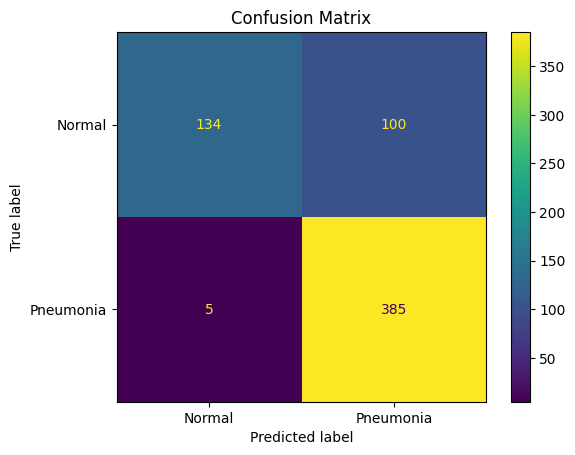

In [4]:
# Cell 1: Setup and Imports
!pip install medmnist torch torchvision matplotlib scikit-learn captum

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import medmnist
from medmnist import INFO
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cell 2: Data Preparation
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

print("Loading datasets...")
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Cell 3: Model Training
def get_resnet18(num_classes=1):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = get_resnet18().to(device)

# Handle class imbalance
n_normal = sum(1 for _, y in train_dataset if y[0] == 0)
n_pneumonia = sum(1 for _, y in train_dataset if y[0] == 1)
pos_weight = torch.tensor([n_normal / n_pneumonia]).to(device)
print(f"Class weights - Normal: {n_normal}, Pneumonia: {n_pneumonia}, Pos weight: {pos_weight.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
train_losses = []
val_aucs = []

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % 20 == 0:
            print(f"Epoch {epoch}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device).float(), target.to(device).float()
            output = model(data)
            all_targets.append(target.cpu().numpy())
            all_outputs.append(torch.sigmoid(output).cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs)
    val_auc = roc_auc_score(all_targets, all_outputs)
    val_aucs.append(val_auc)
    print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val AUC: {val_auc:.4f}")

print("Training completed!")

# Cell 4: Evaluation
model.eval()
test_targets = []
test_outputs = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device).float(), target.to(device).float()
        output = model(data)
        test_targets.append(target.cpu().numpy())
        test_outputs.append(torch.sigmoid(output).cpu().numpy())

test_targets = np.concatenate(test_targets)
test_outputs = np.concatenate(test_outputs)
test_auc = roc_auc_score(test_targets, test_outputs)
test_acc = np.mean((test_outputs > 0.5) == test_targets)
print(f"Test AUC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_targets, test_outputs > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import medmnist
from medmnist import INFO
import numpy as np
import random
import os

# Define the model architecture here (copied from Task 1)
def get_resnet18(num_classes=1):
    model = models.resnet18(weights=None)
    # Modify for grayscale 28x28 images
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove maxpool since images are small
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_resnet_encoder():
    """Create encoder by removing the classifier layer from trained model"""
    model = get_resnet18()

    # Check if trained weights exist
    if os.path.exists('resnet18_pneumonia.pth'):
        model.load_state_dict(torch.load('resnet18_pneumonia.pth', map_location='cpu'))
        print("Loaded trained weights from resnet18_pneumonia.pth")
    else:
        print("Warning: No trained weights found. Using untrained encoder.")

    # Remove the FC layer to create encoder
    encoder = nn.Sequential(*(list(model.children())[:-1]))
    return encoder

class ReportDataset(Dataset):
    def __init__(self, split='train', transform=None):
        data_flag = 'pneumoniamnist'
        info = INFO[data_flag]
        DataClass = getattr(medmnist, info['python_class'])
        self.dataset = DataClass(split=split, transform=transform, download=True)

        # Medical report templates
        self.reports_normal = [
            "The lungs are clear. No evidence of pneumonia.",
            "Normal chest X-ray. No consolidations found.",
            "The heart size is normal. Lungs are well-expanded and clear.",
            "No acute cardiopulmonary findings. Lungs are clear.",
            "Normal examination. No evidence of infection."
        ]
        self.reports_pneumonia = [
            "Opacities observed in the lungs, consistent with pneumonia.",
            "Bilateral consolidations found. Findings suggest pneumonia.",
            "Patchy opacities in both lung fields. Findings suggest pneumonia.",
            "Airspace disease noted. Consistent with pneumonia.",
            "Infiltrates visible in lower lobes. Suggests pneumonia."
        ]

        # Build vocabulary
        self.vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        all_text = " ".join(self.reports_normal + self.reports_pneumonia)
        # Clean and tokenize
        words = []
        for text in all_text.split():
            clean_word = text.replace(".", "").replace(",", "").lower()
            words.append(clean_word)
        words = sorted(list(set(words)))

        for i, word in enumerate(words):
            self.vocab[word] = i + 4
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

        print(f"Vocabulary size: {len(self.vocab)}")

    def tokenize(self, text):
        tokens = [self.vocab["<SOS>"]]
        # Clean and tokenize the text
        for word in text.replace(".", "").replace(",", "").lower().split():
            tokens.append(self.vocab.get(word, self.vocab["<UNK>"]))
        tokens.append(self.vocab["<EOS>"])
        return torch.tensor(tokens)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        label = target[0] if isinstance(target, np.ndarray) else target

        if label == 0:
            report = random.choice(self.reports_normal)
        else:
            report = random.choice(self.reports_pneumonia)

        tokenized_report = self.tokenize(report)
        return img, tokenized_report

def collate_fn(batch):
    """Custom collate function to handle variable length sequences"""
    imgs, reports = zip(*batch)
    imgs = torch.stack(imgs)

    # Pad sequences to the same length
    padded_reports = nn.utils.rnn.pad_sequence(reports, batch_first=True, padding_value=0)

    return imgs, padded_reports

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.3):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        """
        Args:
            features: encoded image features (batch, 512, 1, 1)
            captions: ground truth captions (batch, seq_len)
        """
        # features: (batch, 512, 1, 1) -> (batch, 1, 512)
        features = features.view(features.size(0), 1, -1)

        # Embed captions
        embeddings = self.embed(captions[:, :-1])  # (batch, seq_len-1, embed_size)
        embeddings = self.dropout(embeddings)

        # Concatenate features and embeddings
        inputs = torch.cat((features, embeddings), 1)  # (batch, seq_len, embed_size)

        # Forward through GRU
        hiddens, _ = self.gru(inputs)
        outputs = self.linear(hiddens)

        return outputs

    def sample(self, features, max_len=20):
        """
        Generate caption greedily
        """
        sampled_ids = []
        states = None
        inputs = features.view(features.size(0), 1, -1)  # (batch, 1, embed_size)

        for _ in range(max_len):
            hiddens, states = self.gru(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))  # (batch, vocab_size)
            _, predicted = outputs.max(1)  # (batch)

            sampled_ids.append(predicted.item())

            # Use predicted word as next input
            inputs = self.embed(predicted).unsqueeze(1)

            # Stop if <EOS> token is generated
            if predicted.item() == 2:  # <EOS> token
                break

        return sampled_ids

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # Create datasets and dataloaders
    print("Loading datasets...")
    train_dataset = ReportDataset(split='train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    # Initialize encoder
    encoder = get_resnet_encoder().to(device)
    encoder.eval()  # Keep encoder fixed (no training)

    # Freeze encoder parameters
    for param in encoder.parameters():
        param.requires_grad = False

    # Initialize decoder
    vocab_size = len(train_dataset.vocab)
    decoder = DecoderRNN(embed_size=512, hidden_size=512, vocab_size=vocab_size).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore <PAD> tokens
    optimizer = optim.Adam(decoder.parameters(), lr=0.001)

    # Training loop
    epochs = 10
    print("\nTraining decoder for report generation...")
    print("-" * 50)

    for epoch in range(1, epochs + 1):
        decoder.train()
        total_loss = 0
        num_batches = 0

        for batch_idx, (imgs, reports) in enumerate(train_loader):
            imgs = imgs.to(device)
            reports = reports.to(device)

            # Get image features (encoder is frozen)
            with torch.no_grad():
                features = encoder(imgs)  # (batch, 512, 1, 1)

            # Forward through decoder
            outputs = decoder(features, reports)  # (batch, seq_len, vocab_size)

            # Calculate loss
            loss = criterion(outputs.reshape(-1, vocab_size), reports.reshape(-1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch} completed. Average Loss: {avg_loss:.4f}")

    print("\n" + "=" * 50)
    print("Generating reports for test samples...")
    print("=" * 50)

    # Test dataset for generation
    test_dataset = ReportDataset(split='test', transform=transform)

    # Generate reports for test samples
    for i in range(5):
        img, _ = test_dataset[i]
        label = test_dataset.dataset[i][1][0]

        # Get image features
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            features = encoder(img_tensor)

            # Generate caption
            decoder.eval()
            sampled_ids = decoder.sample(features)

        # Convert ids to words
        words = []
        for word_id in sampled_ids:
            if word_id == 2:  # <EOS>
                break
            if word_id != 1:  # Skip <SOS>
                words.append(train_dataset.inv_vocab.get(word_id, '<UNK>'))

        report = ' '.join(words)
        print(f"Sample {i} (True Label: {'Pneumonia' if label == 1 else 'Normal'}):")
        print(f"Generated: {report}\n")

if __name__ == "__main__":
    main()

Using device: cpu
Loading datasets...
Vocabulary size: 46

Training decoder for report generation...
--------------------------------------------------
Epoch 1, Batch 0/148, Loss: 3.8542
Epoch 1, Batch 10/148, Loss: 0.6505
Epoch 1, Batch 20/148, Loss: 0.3610
Epoch 1, Batch 30/148, Loss: 0.2499
Epoch 1, Batch 40/148, Loss: 0.2724
Epoch 1, Batch 50/148, Loss: 0.2561
Epoch 1, Batch 60/148, Loss: 0.2279
Epoch 1, Batch 70/148, Loss: 0.2493
Epoch 1, Batch 80/148, Loss: 0.2264
Epoch 1, Batch 90/148, Loss: 0.2611
Epoch 1, Batch 100/148, Loss: 0.2608
Epoch 1, Batch 110/148, Loss: 0.2326
Epoch 1, Batch 120/148, Loss: 0.2513
Epoch 1, Batch 130/148, Loss: 0.2651
Epoch 1, Batch 140/148, Loss: 0.2461
Epoch 1 completed. Average Loss: 0.3886
Epoch 2, Batch 0/148, Loss: 0.2550
Epoch 2, Batch 10/148, Loss: 0.2568
Epoch 2, Batch 20/148, Loss: 0.2466
Epoch 2, Batch 30/148, Loss: 0.2515
Epoch 2, Batch 40/148, Loss: 0.2452
Epoch 2, Batch 50/148, Loss: 0.2352
Epoch 2, Batch 60/148, Loss: 0.2337
Epoch 2, Batc

Using device: cpu
Loading datasets...
Train set size: 4708
Test set size: 624

Extracting features from train set...
  Processed batch 0/37
  Processed batch 10/37
  Processed batch 20/37
  Processed batch 30/37
Train features shape: (4708, 512)

Extracting features from test set...
  Processed batch 0/5
Test features shape: (624, 512)

Query #0
Query label: Pneumonia
Top matches:
  1. Similarity: 0.9983, Label: Pneumonia
  2. Similarity: 0.9983, Label: Pneumonia
  3. Similarity: 0.9982, Label: Pneumonia
  4. Similarity: 0.9981, Label: Pneumonia
  5. Similarity: 0.9981, Label: Pneumonia
Saved figure to retrieval_results_q0.png


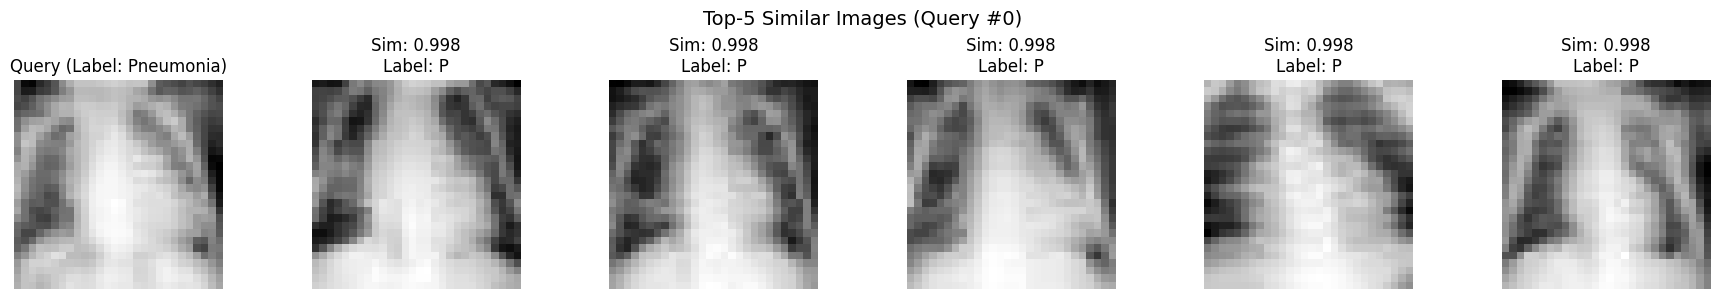


Query #10
Query label: Pneumonia
Top matches:
  1. Similarity: 0.9987, Label: Pneumonia
  2. Similarity: 0.9987, Label: Pneumonia
  3. Similarity: 0.9986, Label: Pneumonia
  4. Similarity: 0.9985, Label: Pneumonia
  5. Similarity: 0.9985, Label: Pneumonia
Saved figure to retrieval_results_q10.png


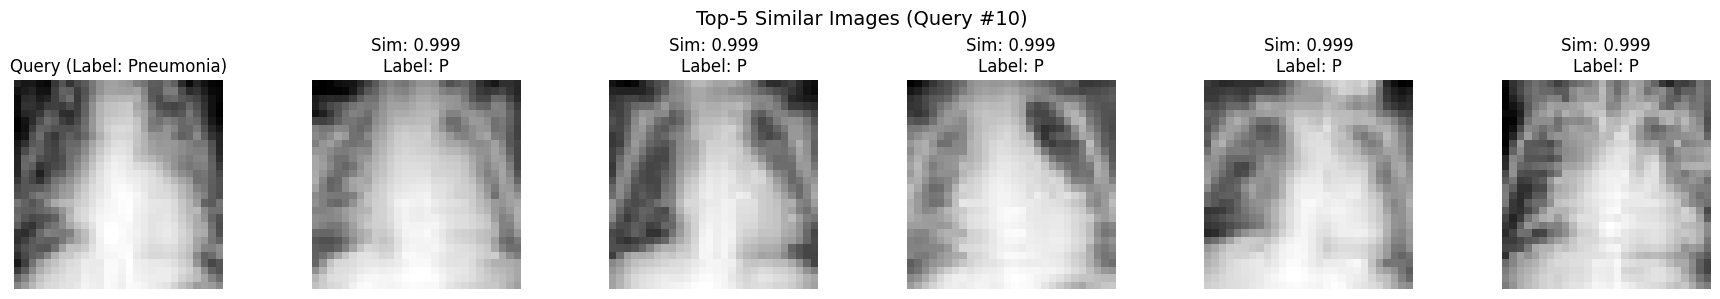


Query #20
Query label: Normal
Top matches:
  1. Similarity: 0.9981, Label: Normal
  2. Similarity: 0.9981, Label: Normal
  3. Similarity: 0.9979, Label: Normal
  4. Similarity: 0.9978, Label: Normal
  5. Similarity: 0.9978, Label: Normal
Saved figure to retrieval_results_q20.png


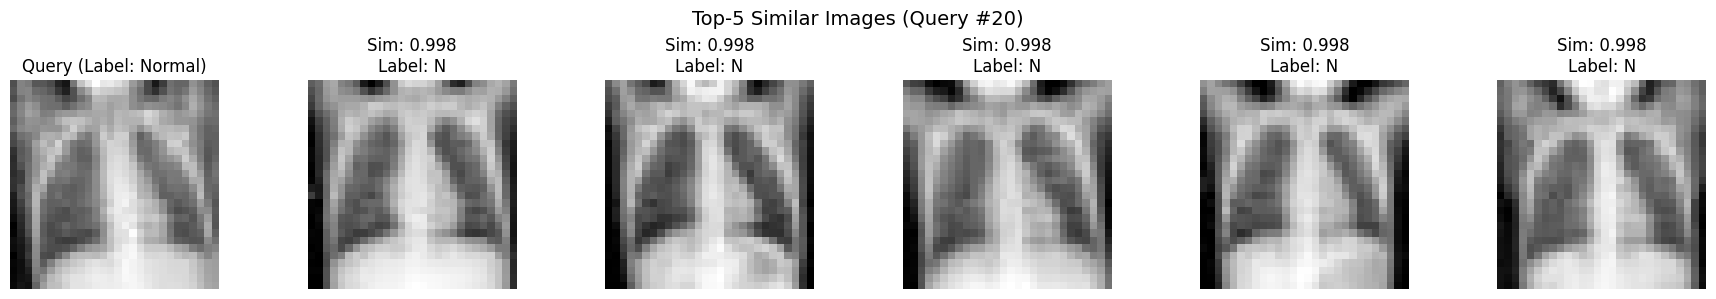


Query #30
Query label: Normal
Top matches:
  1. Similarity: 0.9980, Label: Normal
  2. Similarity: 0.9978, Label: Pneumonia
  3. Similarity: 0.9977, Label: Pneumonia
  4. Similarity: 0.9976, Label: Normal
  5. Similarity: 0.9975, Label: Pneumonia
Saved figure to retrieval_results_q30.png


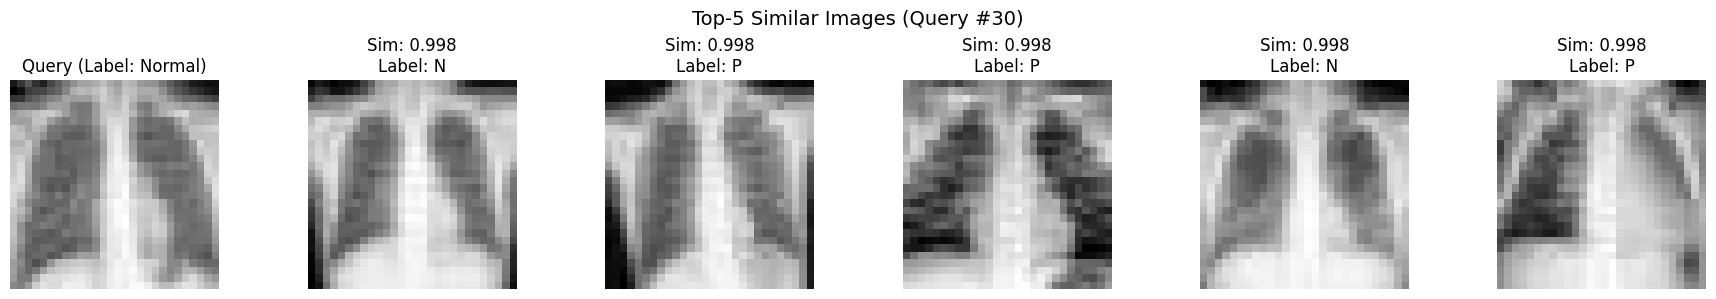


Calculating retrieval accuracy...
Top-5 retrieval accuracy (same label): 94.00%
(Based on 100 test queries)


In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os

# Define the model architecture directly in this file
def get_resnet18(num_classes=1):
    """Create ResNet18 model adapted for grayscale 28x28 images"""
    model = models.resnet18(weights=None)
    # Modify for grayscale input (1 channel instead of 3)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # Remove maxpool since images are small (28x28)
    model.maxpool = nn.Identity()
    # Modify final layer for binary classification
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_encoder():
    """Create encoder from trained ResNet18 by removing classifier"""
    model = get_resnet18()

    # Check if trained weights exist
    weights_path = 'resnet18_pneumonia.pth'
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location='cpu'))
        print(f"Loaded trained weights from {weights_path}")
    else:
        print(f"Warning: No trained weights found at {weights_path}. Using untrained encoder.")

    # Remove the FC layer to use as feature extractor
    # This takes all layers except the last one (classifier)
    encoder = nn.Sequential(*(list(model.children())[:-1]))
    return encoder

def extract_features(model, loader, device):
    """Extract features from all images in a dataloader"""
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for batch_idx, (imgs, targets) in enumerate(loader):
            imgs = imgs.to(device).float()

            # Extract features
            feat = model(imgs)
            # Flatten features: (batch, 512, 1, 1) -> (batch, 512)
            feat = feat.view(feat.size(0), -1)

            features.append(feat.cpu().numpy())
            labels.append(targets.numpy())

            if batch_idx % 10 == 0:
                print(f"  Processed batch {batch_idx}/{len(loader)}")

    return np.concatenate(features), np.concatenate(labels)

def visualize_retrieval(query_idx, query_img, query_label, train_dataset,
                        train_labels, top_indices, similarities, save_path=None):
    """Visualize query and retrieved images"""
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))

    # Query image
    axes[0].imshow(query_img[0], cmap='gray')
    axes[0].set_title(f"Query (Label: {'Pneumonia' if query_label==1 else 'Normal'})")
    axes[0].axis('off')

    # Retrieved images
    for i, idx in enumerate(top_indices):
        img, _ = train_dataset[idx]
        sim = similarities[idx]
        label = train_labels[idx][0]

        axes[i+1].imshow(img[0], cmap='gray')
        axes[i+1].set_title(f"Sim: {sim:.3f}\nLabel: {'P' if label==1 else 'N'}")
        axes[i+1].axis('off')

    plt.suptitle(f"Top-5 Similar Images (Query #{query_idx})", fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()

def main():
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # Load dataset
    data_flag = 'pneumoniamnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])

    print("Loading datasets...")
    train_dataset = DataClass(split='train', transform=transform, download=True)
    test_dataset = DataClass(split='test', transform=transform, download=True)

    print(f"Train set size: {len(train_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize encoder
    encoder = get_encoder().to(device)
    encoder.eval()

    # Extract features
    print("\nExtracting features from train set...")
    train_features, train_labels = extract_features(encoder, train_loader, device)
    print(f"Train features shape: {train_features.shape}")

    print("\nExtracting features from test set...")
    test_features, test_labels = extract_features(encoder, test_loader, device)
    print(f"Test features shape: {test_features.shape}")

    # Normalize features for better cosine similarity
    train_features = train_features / np.linalg.norm(train_features, axis=1, keepdims=True)
    test_features = test_features / np.linalg.norm(test_features, axis=1, keepdims=True)

    # Try multiple query examples
    query_indices = [0, 10, 20, 30]  # Try different test samples

    for query_idx in query_indices:
        print(f"\n{'='*50}")
        print(f"Query #{query_idx}")

        query_feat = test_features[query_idx].reshape(1, -1)
        query_label = test_labels[query_idx][0]
        query_img, _ = test_dataset[query_idx]

        # Calculate cosine similarity with all train features
        similarities = cosine_similarity(query_feat, train_features).flatten()

        # Get top 5 most similar images
        top_k_indices = similarities.argsort()[-5:][::-1]

        print(f"Query label: {'Pneumonia' if query_label==1 else 'Normal'}")
        print("Top matches:")
        for i, idx in enumerate(top_k_indices):
            sim = similarities[idx]
            label = train_labels[idx][0]
            print(f"  {i+1}. Similarity: {sim:.4f}, Label: {'Pneumonia' if label==1 else 'Normal'}")

        # Visualize
        visualize_retrieval(
            query_idx=query_idx,
            query_img=query_img,
            query_label=query_label,
            train_dataset=train_dataset,
            train_labels=train_labels,
            top_indices=top_k_indices,
            similarities=similarities,
            save_path=f'retrieval_results_q{query_idx}.png'
        )

    # Calculate retrieval accuracy (optional)
    print("\n" + "="*50)
    print("Calculating retrieval accuracy...")

    correct_retrievals = 0
    total_queries = min(100, len(test_features))  # Use first 100 test samples

    for i in range(total_queries):
        query_feat = test_features[i].reshape(1, -1)
        query_label = test_labels[i][0]

        similarities = cosine_similarity(query_feat, train_features).flatten()
        top_k_indices = similarities.argsort()[-5:][::-1]

        # Check if any of the top-5 retrievals have the same label
        retrieved_labels = train_labels[top_k_indices][:, 0]
        if query_label in retrieved_labels:
            correct_retrievals += 1

    accuracy = correct_retrievals / total_queries * 100
    print(f"Top-5 retrieval accuracy (same label): {accuracy:.2f}%")
    print(f"(Based on {total_queries} test queries)")

if __name__ == "__main__":
    main()